# Flow imbalances
One of the drawbacks with station-based bike shares like Divvy (as opposed to other types like Lime Bike that are dispersed) is that since travel direction is not always balanced, you have to manually redistribute bikes (note: as of 11/6/2018 a large portion of Divvy job postings are for temp workers to do just that). This notebook examines aggregate imbalances. 

## Conclusions:
There are strong geographic patterns, not all of which make logical sense. Mostly, you see a large sink in Navy Pier (likely tourists biking there but not back), and downtown tends to be a source and residential neighborhoods sinks. 
<br> NOTE - this does not account for temporary imbalances such as commutes
<br> interestingly, Chicago is so flat that you don't see what happened in Seattle, where bikes would aggregate at the bottom of hills. 

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import folium
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load from lib
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.download_data import load_trip_data, load_station_data
from lib.visualization import map_stations

In [3]:
%%time
df = load_trip_data()

Wall time: 55.7 s


In [4]:
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,start_datetime,end_datetime
0,4118,2013-06-27 12:11,2013-06-27 12:16,480,316,85,Michigan Ave & Oak St,28,Larrabee St & Menomonee St,Customer,NaN,NaN,2013-06-27 12:11:00,2013-06-27 12:16:00
1,4275,2013-06-27 14:44,2013-06-27 14:45,77,64,32,Racine Ave & Congress Pkwy,32,Racine Ave & Congress Pkwy,Customer,NaN,NaN,2013-06-27 14:44:00,2013-06-27 14:45:00
2,4291,2013-06-27 14:58,2013-06-27 15:05,77,433,32,Racine Ave & Congress Pkwy,19,Loomis St & Taylor St,Customer,NaN,NaN,2013-06-27 14:58:00,2013-06-27 15:05:00
3,4316,2013-06-27 15:06,2013-06-27 15:09,77,123,19,Loomis St & Taylor St,19,Loomis St & Taylor St,Customer,NaN,NaN,2013-06-27 15:06:00,2013-06-27 15:09:00
4,4342,2013-06-27 15:13,2013-06-27 15:27,77,852,19,Loomis St & Taylor St,55,Halsted St & James M Rochford St,Customer,NaN,NaN,2013-06-27 15:13:00,2013-06-27 15:27:00


In [5]:
df['trips'] = 1
trips_from_station = df.groupby('from_station_id')['trips'].sum().reset_index()
trips_from_station.rename(columns = {'from_station_id':'id', 'trips':'trips_from'}, inplace=True)
trips_to_station = df.groupby('to_station_id')['trips'].sum().reset_index()
trips_to_station.rename(columns = {'to_station_id':'id', 'trips':'trips_to'}, inplace=True)

In [6]:
df_stations = pd.merge(trips_from_station, trips_to_station, how='outer').fillna(0)
df_stations = pd.merge(df_stations, load_station_data(), how='inner') # NOTE - a few stations aren't in the latest station data

In [7]:
df_stations.head()

,id,trips_from,trips_to,name,city,latitude,longitude,dpcapacity,online_date,Unnamed: 7,online_datetime,online_month,online_year
0,2,48144,44771.0,Buckingham Fountain,Chicago,41.876393,-87.620328,27,2013-06-10,NaN,2013-06-10 10:43:00,2013-06,2013
1,3,93204,89264.0,Shedd Aquarium,Chicago,41.867226,-87.615355,55,2013-06-10,NaN,2013-06-10 10:44:00,2013-06,2013
2,4,64164,64889.0,Burnham Harbor,Chicago,41.856268,-87.613348,23,2013-06-10,NaN,2013-06-10 10:46:00,2013-06,2013
3,5,40652,42254.0,State St & Harrison St,Chicago,41.874053,-87.627716,23,2013-06-10,NaN,2013-06-10 10:46:00,2013-06,2013
4,6,67028,58458.0,Dusable Harbor,Chicago,41.885041,-87.612794,39,2013-06-10,NaN,2013-06-10 11:18:00,2013-06,2013


In [8]:
df_stations['flow'] = df_stations.trips_to - df_stations.trips_from
df_stations['flow_abs'] = np.abs(df_stations.flow)
df_stations['flow_relative'] = df_stations.trips_to / df_stations.trips_from
df_stations['flow_relative_abs'] = np.abs(df_stations.flow_relative)

### To start, let's color by sink/source if there's a >= 10% difference between rides to and from station. Size will correspond to the absolute difference in rides to/from 

In [9]:
df_stations['color'] = 'black'
# df_stations.loc[df_stations.flow > 0, 'color'] = 'blue'
# df_stations.loc[df_stations.flow < 0, 'color'] = 'red'
df_stations.loc[df_stations.flow_relative >= 1.05, 'color'] = 'blue'
df_stations.loc[df_stations.flow_relative <= 0.95, 'color'] = 'red'

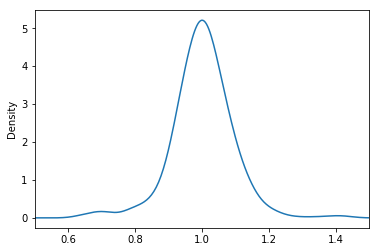

In [10]:
df_stations.flow_relative.plot.kde(xlim=(0.5,1.5))

In [11]:
map_stations(df_stations, 'flow_abs')

# Okay, now can we use the median time that a given bike sits at a given station, as a proxy of usage
- Median should help remove influence of odd events such as maintenance
- Not sure what (if anything) to do about overnight docking. If you just thought about commutes, dock time should be much longer in residential neighborhoods than downtown. 

In [12]:
# ensure that it's sorted correctly by date
df.sort_values(['bikeid', 'start_datetime'], ascending=True, inplace=True)
df.head()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,start_datetime,end_datetime,trips
406,7089,2013-06-28 18:52,2013-06-28 19:17,1,1539,62,McCormick Place,88,May St & Randolph St,Customer,NaN,NaN,2013-06-28 18:52:00,2013-06-28 19:17:00,1
796,8229,2013-06-29 13:38,2013-06-29 14:07,1,1710,88,May St & Randolph St,71,Morgan St & Lake St,Customer,NaN,NaN,2013-06-29 13:38:00,2013-06-29 14:07:00,1
1134,8870,2013-06-29 16:56,2013-06-29 18:00,1,3852,71,Morgan St & Lake St,71,Morgan St & Lake St,Customer,NaN,NaN,2013-06-29 16:56:00,2013-06-29 18:00:00,1
1279,9139,2013-06-29 18:20,2013-06-29 18:26,1,363,71,Morgan St & Lake St,88,May St & Randolph St,Customer,NaN,NaN,2013-06-29 18:20:00,2013-06-29 18:26:00,1
1372,9307,2013-06-29 19:22,2013-06-29 19:49,1,1618,88,May St & Randolph St,17,Wood St & Division St,Customer,NaN,NaN,2013-06-29 19:22:00,2013-06-29 19:49:00,1


In [13]:
df['count'] = df.groupby('bikeid').cumcount()

In [14]:
# Remember: we are interested in the time BETWEEN rides, NOT the rides themselves
df0 = df[['bikeid', 'count', 'to_station_id', 'end_datetime']]
df0.rename(columns={'to_station_id': 'previous_ride_end_id', 'end_datetime': 'previous_ride_end_datetime'}, inplace=True)
df1 = df.loc[df['count'] > 0][['bikeid', 'count', 'from_station_id', 'start_datetime']]
df1.rename(columns={'from_station_id': 'next_ride_start_id', 'start_datetime': 'next_ride_start_datetime'}, inplace=True)
df1['count'] = df1['count'] - 1
df_merged = pd.merge(df0, df1)

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [15]:
df_merged.shape

(15262698, 6)

In [16]:
df_merged['same_station'] = df_merged.previous_ride_end_id == df_merged.next_ride_start_id
df_merged.same_station.value_counts(normalize=True)

True     0.884355
False    0.115645
Name: same_station, dtype: float64

In [17]:
df_merged['docked_time'] = df_merged.next_ride_start_datetime - df_merged.previous_ride_end_datetime

In [18]:
df_merged.docked_time.describe()

count                  15262698
mean     0 days 12:21:58.559534
std      4 days 01:48:04.073837
min           -1 days +09:08:00
25%             0 days 00:19:31
50%             0 days 01:39:04
75%             0 days 09:11:00
max          1409 days 16:00:58
Name: docked_time, dtype: object

In [24]:
df_docktime = df_merged.loc[df_merged.same_station].groupby('next_ride_start_id')['docked_time'].agg({'trips': 'count',
                                                                                                     'median_docktime': lambda x: np.median(x)})
# .apply(lambda x: np.median(x))

df_docktime = df_docktime.reset_index().rename(columns={'next_ride_start_id':'id'})

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


In [32]:
df_docktime.head()

,id,trips,median_docktime,median_docktime_seconds
0,2,42655,00:31:13,1873
1,3,85128,00:18:22.500000,1102
2,4,62786,00:04:23,263
3,5,36530,01:54:00,6840
4,6,56710,00:09:00,540


In [41]:
df_docktime['median_docktime_seconds'] = df_docktime.median_docktime.apply(lambda x: x.seconds)
df_docktime['median_docktime_hours'] = df_docktime.median_docktime.apply(lambda x: x.seconds/(60*60))

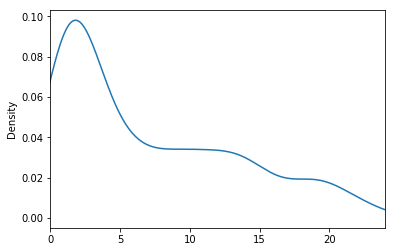

In [43]:
df_docktime.median_docktime_hours.plot.kde(xlim=(0,24))

In [33]:
df_docktime = pd.merge(df_docktime, load_station_data())

In [45]:
df_docktime['color'] = 'black'
df_docktime.loc[df_docktime.median_docktime_hours > 12, 'color'] = 'red'
map_stations(df_docktime, 'median_docktime_hours')

# TODO 
- I should be making one master df_stations (should this be done mostly in the repo?)
- How can I combine the measures of usage? can I get ranks, and see which stations maybe aren't used that much in terms of trips, but have a low median wait time? I'm not sure yet what this median wait time tells me that I didn't already know. BUT what's with the peripheral stations with low dock times? Are these possibly the source stations, where there's demand that isn't met because there aren't bikes? 
- How can I use ML algorithms to detect the spatial outliers, e.g. stations that don't match their neighbors interms of docktime, usage, source/sink, etc? Will this give me clues as to what features could be useful for station usage? 
- honestly first I should just scatter the usage metrics against each other (e.g. source/sink ratio vs median wait time)
- BUT first the station metrics should all be combined into the repo 

## Pipe dream: 
- Use yelp API (https://www.yelp.com/developers/documentation/v3/business_search) to pull the the most popular business and/or restaurant/bar (either by rating or just number of reviews). 
- For fun (maybe as a first API call), could you get a list of all starbucks in Chicago and calculate distance to nearest one? 
- I think this needs to be very carefully thought out